# Number Classification Using the MNIST Dataset

This notebook contains sample code to classify digits using the MNIST Dataset and the solutions to **Chapter 3 assignment.**

**About Dataset:**

The MNIST dataset contains 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

**Credit:**

O'Reilly book Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow

# Libraries

In [1]:
#sklearn
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# numpy and os
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# Import Dataset

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame= False)

mnist.keys()  # print dictionary keys

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by `Scikit-Learn` generally have a similar dictionary structure including:

• A `DESCR` key describing the dataset

• A `data` key containing an array with one row per instance and one column per feature

• A `target` key containing an array with the labels


# Quick Look at Data Structure

In [3]:
# assign the data to X and labels to y

X, y = mnist["data"], mnist["target"]

In [4]:
# print the number of rows and columns in the dataset
X.shape

(70000, 784)

**Interpretation:**

    
This means that there are 70000 images (instances) and 784 (attributes)

In [5]:
# print the number of rows and columns in the label
y.shape

(70000,)

**Interpretation:**


This means that there are labels for the entire 70000 images (instances). But no other attribute column in the label.

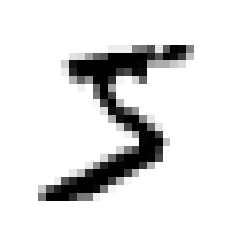

In [6]:
# View 1-digit
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

# Use Matplotlib's `imshow()` 
plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

In [7]:
# label
y[0]

'5'

Apparently, the label is a string. Let’s covert y to integers since we prefer to work with numbers.

In [8]:
y = y.astype(np.uint8)

y[0]

5

# Create at Test Set

The MNIST dataset is actually already split into:

    a training set (the first 60,000 images) 

    and a test set (the last 10,000 images):

In [9]:
# create a train and test set for both the data and label

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen.

The training set is already shuffled for us, which is good as this guarantees that all cross-validation folds will be similar (you don’t want one fold to be missing some digits).

# Training a Binary Classifier 
## (5-detector)

This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5

In [10]:
# create target vectors for the classifier
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

# SELECT AND TRAIN A MODEL

## Stochastic Gradient Descent (SGD) classifier

This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning).

The SGDClassifier relies on randomness during training (hence the name “stochastic”). If you want reproducible results, you should set the random_state parameter.

In [11]:
#  create an SGDClassifier and 
sgd_clf = SGDClassifier(random_state=42)

# train on the `whole training set` (X and y)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
# predict `5` or `not 5`
sgd_clf.predict([some_digit])

array([ True])

# MEASURING ACCURACY

## Cross-Validation (StratifiedKFold)

The following code does roughly the same thing as Scikit Learn’s `cross_val_score()` function, and it prints the same result:

In [13]:
skfolds = StratifiedKFold(n_splits=3, shuffle = True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565, and 0.96495

0.9669
0.91625
0.96785


The `StratifiedKFold` class performs stratified sampling to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

## Alternatively, 
## Cross-Validation (cross_val_score)

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

This uses the `cross_val_score()` function to evaluate our `SGDClassifier model`, using K-fold cross-validation with three folds. Remember that K-fold cross-validation means splitting the training set into K folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds.

**Accuracy above 95%** (ratio of correct predictions) on the 3 cross-validation folds looks impressive!

But before you get too excited, let’s look at a very dumb classifier that just **classifies every single image in the “not-5” class**

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


In [16]:
# measure accuracy of the dumb classifier
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

**Interpretation:**

**It has over 90% accuracy** because `only about 10% of the images are 5s`, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.

This demonstrates why `accuracy` is generally not the preferred performance measure for classifiers, especially when you are dealing with `skewed datasets` (i.e., when some classes are much more frequent than others)

## Confusion Matrix

This is arguably the best method to evaluate the performance of a `classifier`. `Confusion matrix` counts the number of times instances of `class A` are classified as `class B`.

To compute the confusion matrix, you **first need to have a set of predictions** `so that they can be compared to the actual targets`. 

You could make predictions on the test set, but let’s keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to
launch). Instead, you can use the `cross_val_predict()` function:


In [17]:
# create predictions using `cross_val_predict`

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

y_train_pred

array([ True, False, False, ...,  True, False, False])

## `cross_val_score() function` Vs `cross_val_predict()`

Both `cross_val_score()` and `cross_val_predict()` function performs **K-fold cross-validation**, but instead of returning the evaluation scores, it returns the predictions made on each test fold. 

This means that you get a `clean` prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).


In [18]:
# print confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

**Interpretation:**

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 53,892 of them were correctly classified as non-5s (they are called true negatives), while the remaining 687 were wrongly classified as 5s (false positives).


The second row considers the images of 5s (the positive class): 1,891 were wrongly classified as non-5s (false negatives), while the remaining 3,530 were correctly classified as 5s (true positives). 

**A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right).**

In [19]:
# let's pretend to have a perfect prediction

y_train_perfect_predictions = y_train_5      # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)


array([[54579,     0],
       [    0,  5421]], dtype=int64)

# Precision and Recall of positive predictions

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric for the positive predictions. 

   1. `Precision`: This is the accuracy of the positive predictions; this is called the **precision of the classifier.**
   2. `Recall`: This is the ratio of positive instances that are correctly detected by the classifier; this is also called **sensitivity or the true positive rate (TPR)** 
   
A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = 1/1 = 100%). But this would not be very useful, since the classifier would ignore all but one positive instance. So precision is typically used along with another metric named recall.

In [20]:
# compute the precision and recall metrics of classifier
from sklearn.metrics import precision_score, recall_score

# precision score
precision_score(y_train_5, y_train_pred) # == 3530 / (3530 + 687)

0.8370879772350012

In [21]:
# classifier score
recall_score(y_train_5, y_train_pred) # == 3530 / (3530 + 687)

0.6511713705958311

**Interpretation:**

Now your 5-detector does not look as shiny as it did when you looked at its accuracy.

When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.

## Harmonic mean of Precision and Recall (F1-Score)

It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

In [22]:
# compute F1 score

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

**The F1 score favors classifiers that have similar precision and recall**. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. 

## Precision/Recall Trade-off

Unfortunately, increasing precision reduces recall, and vice versa; this is called the `precision/recall trade-off`.

`Scikit-Learn` will not allow us to set a `threshold` directly, but it does give you access to the `decision scores` that it uses to make predictions.

Instead of calling the classifier’s `predict() method`, you can call its `decision_function()` method, which returns a
score for each instance, and then use any threshold you want to make predictions based on those scores:


In [23]:
# find decision score

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
# Use threshold = 0 for classifier

threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

**Interpretation:**

The `SGDClassifier` uses a `threshold equal to 0`, so the code returns the same result as the `predict()` method (i.e., True).

In [25]:
# Increase classifier threshold

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

**Interpretation:**

The `SGDClassifier` uses a `threshold equal to 8,000`, so the code returns the opposite result as the `predict()` method (i.e., False).

This confirms that `raising the threshold decreases recall`. **The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8,000.**

**HOW TO DECIDE WHICH THRESHOLD TO USE?**

1. First, use the `cross_val_predict()` function `to get the scores of all instances in the training set`, **but this time specify that you want to return `decision scores` instead of `predictions`:**


In [26]:
# compute the decision scores for all instances (rows) in the training set
y_scores = cross_val_predict(sgd_clf, 
                             X_train, 
                             y_train_5, 
                             cv=3, 
                             method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

2. Now let's use the `y_score` and `precision_recall_curve()` function to compute `precision` and `recall` for all possible thresholds:

In [27]:
# compute `precision` and `recall` for all thresolds

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

3. Finally, use Matplotlib to plot `precision` and `recall` as functions of the `threshold value`

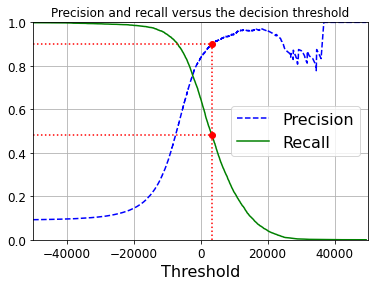

In [32]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16) 
    plt.grid(True)                          
    plt.axis([-50000, 50000, 0, 1]) 

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                               
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                           

plt.title("Precision and recall versus the decision threshold")
plt.show()

In [29]:
k

NameError: name 'k' is not defined

# Assignment 2

# 1.

Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

# 2.

Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel.5 Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set.
You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

# 3.

Tackle the Titanic dataset. A great place to start is on Kaggle.

# 4.

Build a spam classifier (a more challenging exercise):
    
    • Download examples of spam and ham from Apache SpamAssassin’s public datasets.
    
    • Unzip the datasets and familiarize yourself with the data format.
    
    • Split the datasets into a training set and a test set.
    
    • Write a data preparation pipeline to convert each email into a feature vector. Your preparation pipeline should transform an email into a (sparse) vector indicating the presence or absence of each possible word. For example, if all emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email “Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1] (meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word.
    
    • You may want to add hyperparameters to your preparation pipeline to control whether or not to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with “URL,” replace all numbers with “NUMBER,” or even perform stemming (i.e., trim off word endings; there are Python libraries available to do this).
    
    • Then try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision.